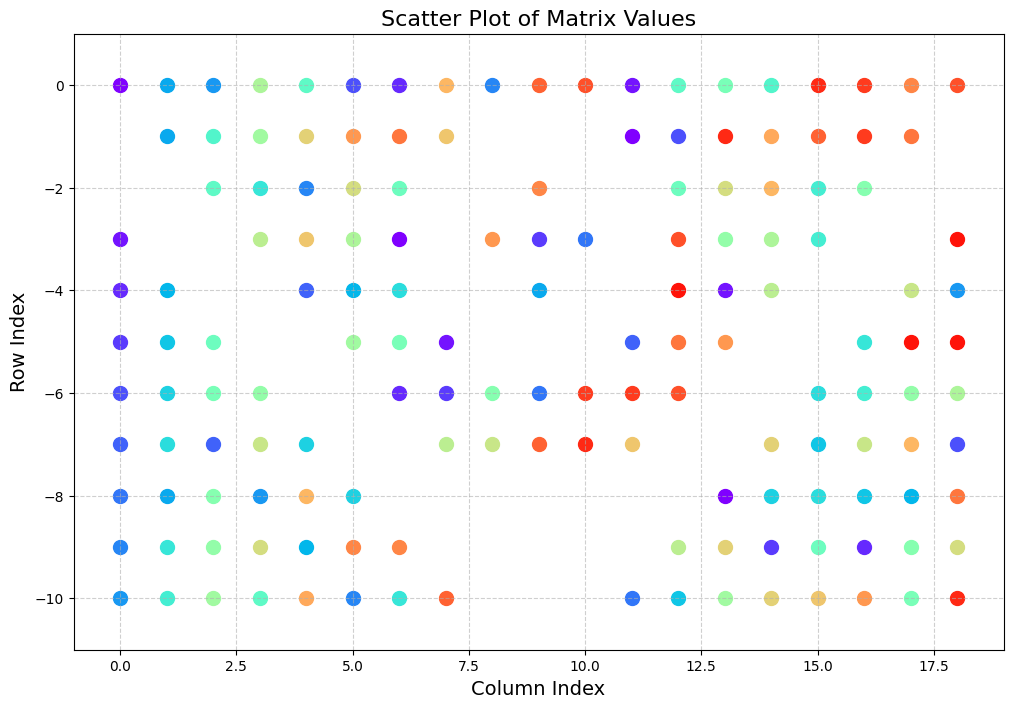

In [1]:
import sys
import os
sys.path.append('..')
from utils import plot_map
import json
from PIL import Image

plot_map('map.json',None,show=1)
 

In [2]:
# 用 map[x][y] 来访问对应坐标的方块
def get_image_hash(image):
    # 取样本像素点的rgb，计算hash值
    value = ''
    for x in range(2, 8):
        for y in range(2, 8):
            #print(image.getpixel((x*3, y*3)))
            r, g, b = image.getpixel((x*3, y*3))
            value += "({}, {}, {})".format(r, g, b)
    return hash(value)
COL_NUM = 19
ROW_NUM = 11

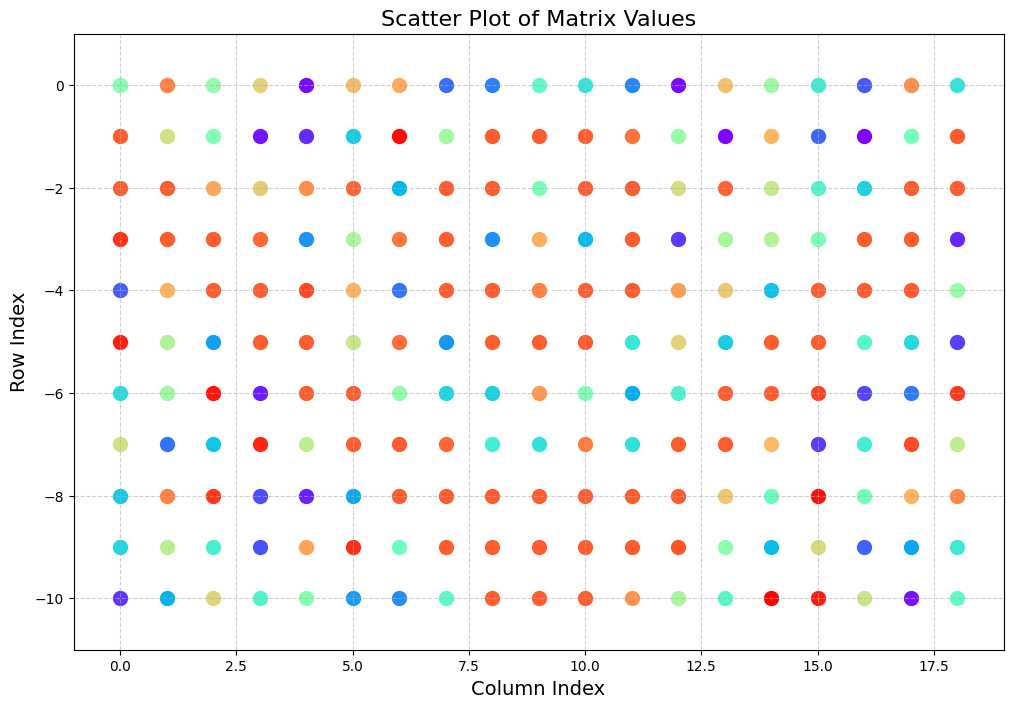

In [3]:

def get_map(image):
    game_map = []
    _, _, area_width, area_height = image.getbbox()
    global SQUARE_WIDTH, SQUARE_HEIGHT
    SQUARE_WIDTH = area_width / COL_NUM
    SQUARE_HEIGHT = area_height / ROW_NUM
    for x in range(COL_NUM):
        a_col = []
        for y in range(ROW_NUM):
            square = image.crop((
                x * SQUARE_WIDTH, y * SQUARE_HEIGHT,
                (x+1) * SQUARE_WIDTH, (y+1) * SQUARE_HEIGHT))
            a_col.append(get_image_hash(square))
            #square.save("log/figs/({x},{y}).png".format(x=x,y=y))
        game_map.append(a_col)
    return game_map

#Image.open('cropped_screen.png').show()
map_dbg = get_map(Image.open('cropped_screen.png'))

with open('map_dbg.json','w') as file:
    json.dump(map_dbg,file)
    

plot_map('map_dbg.json',None,show=1)

(x,y)=(0,0) [(0, 0), (6, 3), (11, 1), (13, 8)]
(ix,iy)=(0,0)
(ix,iy)=(6,3)
(ix,iy)=(11,1)
(ix,iy)=(13,8)
(x,y)=(0,3) [(0, 3), (7, 5), (11, 0), (13, 4)]
(ix,iy)=(0,3)
(ix,iy)=(7,5)
(ix,iy)=(11,0)
(ix,iy)=(13,4)
(x,y)=(0,4) [(0, 4), (6, 0), (6, 6), (16, 9)]
(ix,iy)=(0,4)
(ix,iy)=(6,0)
(ix,iy)=(6,6)
(ix,iy)=(16,9)
(x,y)=(0,5) [(0, 5), (7, 6), (9, 3), (14, 9)]
(ix,iy)=(0,5)
(ix,iy)=(7,6)
(ix,iy)=(9,3)
(ix,iy)=(14,9)
(x,y)=(0,6) [(0, 6), (5, 0), (12, 1), (18, 7)]
(ix,iy)=(0,6)
(ix,iy)=(5,0)
(ix,iy)=(12,1)
(ix,iy)=(18,7)
(x,y)=(0,7) [(0, 7), (2, 7), (4, 4), (11, 5)]
(ix,iy)=(0,7)
(ix,iy)=(2,7)
(ix,iy)=(4,4)
(ix,iy)=(11,5)
(x,y)=(0,8) [(0, 8), (9, 6), (10, 3), (11, 10)]
(ix,iy)=(0,8)
(ix,iy)=(9,6)
(ix,iy)=(10,3)
(ix,iy)=(11,10)
(x,y)=(0,9) [(0, 9), (4, 2), (5, 10), (8, 0)]
(ix,iy)=(0,9)
(ix,iy)=(4,2)
(ix,iy)=(5,10)
(ix,iy)=(8,0)
(x,y)=(0,10) [(0, 10), (2, 0), (3, 8), (18, 4)]
(ix,iy)=(0,10)
(ix,iy)=(2,0)
(ix,iy)=(3,8)
(ix,iy)=(18,4)
(x,y)=(1,0) [(1, 0), (1, 1), (1, 8), (9, 4)]
(ix,iy)=(1,0)
(

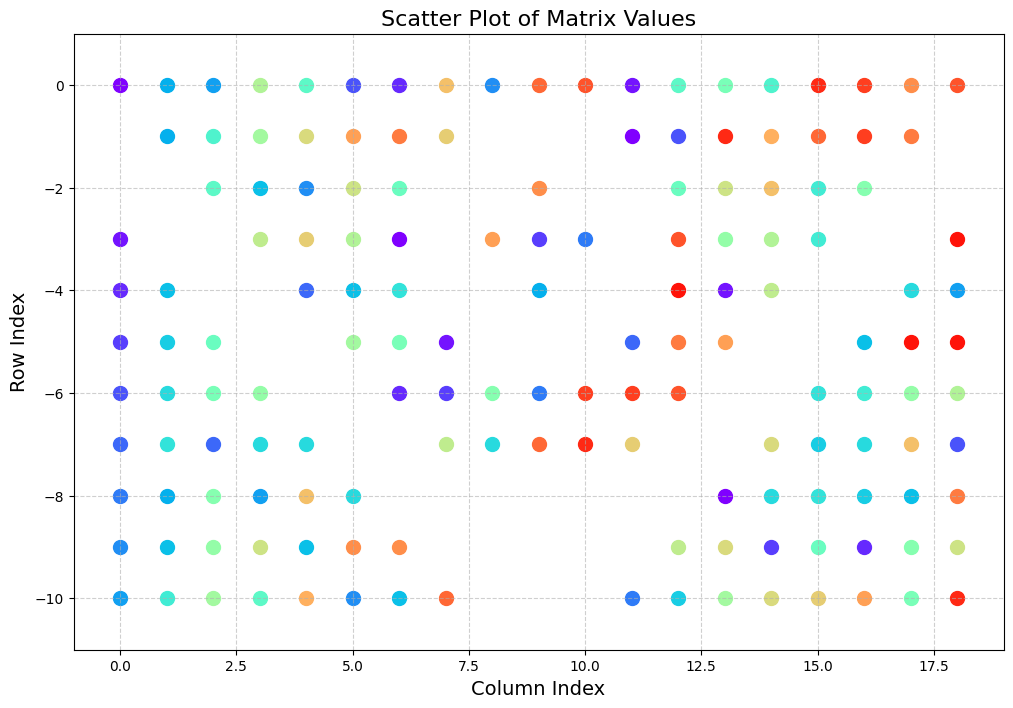

In [4]:
import numpy as np
import cv2
from pathlib import Path
dbg = 1

# check if a image is blank
# we compare the middle 1/3 of the image, if it fills with the same color, then blank
def check_blank(im):
    cropped_image = im.crop((13, 13, 26, 26))
    im_array = np.array(cropped_image).reshape(-1,3)
    return np.array_equal(np.max(im_array, axis=0) - np.min(im_array, axis=0),  np.array([0,0,0]))

def get_same_imgs_3(square,image,SQUARE_WIDTH,SQUARE_HEIGHT):# Convert PIL images to OpenCV format (NumPy arrays)
    res = []
    res_dbg = []
    dbg_mat = []
    for x in range(COL_NUM):
        for y in range(ROW_NUM):
            square_xy = image.crop((
                x * SQUARE_WIDTH, y * SQUARE_HEIGHT,
                (x+1) * SQUARE_WIDTH, (y+1) * SQUARE_HEIGHT))           
            # first cast into same shape
            min_shape =  [min(x, y) for x, y in zip(np.array(square_xy).shape, np.array(square).shape)]
            # print(min_shape)
            cs = 5 # crop size
            crop_square_xy = np.array(square_xy).astype(np.int64)[cs:min_shape[0]-cs,cs:min_shape[1]-cs,:]
            crop_square = np.array(square).astype(np.int64)[cs:min_shape[0]-cs,cs:min_shape[1]-cs,:]
            diff = crop_square_xy-crop_square
            dist = np.linalg.norm(diff.flatten(),ord=1)
            if dist < 100000.:
                res.append((x,y))
                #print(dist,"(small)")
            else:
                #print(dist)
                pass
    return res

def get_map_3(image):
    max_ind = 1
    _, _, area_width, area_height = image.getbbox()
    global SQUARE_WIDTH, SQUARE_HEIGHT
    SQUARE_WIDTH = area_width / COL_NUM
    SQUARE_HEIGHT = area_height / ROW_NUM
    game_map = [ [-1 for j in  range(ROW_NUM)] for i in range(COL_NUM)]
    for x in range(COL_NUM):
        for y in range(ROW_NUM):
            square = image.crop((
                x * SQUARE_WIDTH, y * SQUARE_HEIGHT,
                (x+1) * SQUARE_WIDTH, (y+1) * SQUARE_HEIGHT))
            if dbg:
                save_path = Path("log/figs/({x},{y}).png".format(x=x,y=y))
                save_path.parent.mkdir(parents=True, exist_ok=True)
                square.save(save_path)
            if check_blank(square) == True:
                assert game_map[x][y] == -1
                game_map[x][y] = 0
            elif game_map[x][y] == -1:
                same_imgs = get_same_imgs_3(square,image,SQUARE_WIDTH,SQUARE_HEIGHT)
                print("(x,y)=({x},{y})".format(x=x,y=y),same_imgs)
                for ix,iy in same_imgs:
                    print("(ix,iy)=({ix},{iy})".format(ix=ix,iy=iy))
                    assert game_map[ix][iy] == -1
                    game_map[ix][iy] = max_ind
                max_ind += 1
                
    return game_map



im = Image.open('cropped_screen.png')
map_dbg = get_map_3(im)

with open('map_dbg.json','w') as file:
    json.dump(map_dbg,file)
    

plot_map('map_dbg.json',None,show=1)

[(4, 0), (14, 4), (4, 3), (3, 1), (3, 10), (2, 2), (13, 8), (7, 7), (15, 8), (12, 0), (12, 9), (3, 3), (11, 1), (2, 10), (13, 10), (6, 4), (5, 5), (0, 0), (1, 7), (15, 6), (6, 3)]
(x,y)=(0,0) [(13, 8), (11, 1), (0, 0), (6, 3)]
(ix,iy)=(13,8)
(ix,iy)=(11,1)
(ix,iy)=(0,0)
(ix,iy)=(6,3)
[(13, 4), (0, 3), (7, 5), (11, 0)]
(x,y)=(0,3) [(13, 4), (0, 3), (7, 5), (11, 0)]
(ix,iy)=(13,4)
(ix,iy)=(0,3)
(ix,iy)=(7,5)
(ix,iy)=(11,0)
[(6, 6), (16, 9), (0, 4), (6, 0)]
(x,y)=(0,4) [(6, 6), (16, 9), (0, 4), (6, 0)]
(ix,iy)=(6,6)
(ix,iy)=(16,9)
(ix,iy)=(0,4)
(ix,iy)=(6,0)
[(7, 6), (14, 9), (9, 3), (0, 5)]
(x,y)=(0,5) [(7, 6), (14, 9), (9, 3), (0, 5)]
(ix,iy)=(7,6)
(ix,iy)=(14,9)
(ix,iy)=(9,3)
(ix,iy)=(0,5)
[(12, 1), (5, 0), (18, 7), (0, 6)]
(x,y)=(0,6) [(12, 1), (5, 0), (18, 7), (0, 6)]
(ix,iy)=(12,1)
(ix,iy)=(5,0)
(ix,iy)=(18,7)
(ix,iy)=(0,6)
[(4, 4), (0, 7), (2, 7), (11, 5)]
(x,y)=(0,7) [(4, 4), (0, 7), (2, 7), (11, 5)]
(ix,iy)=(4,4)
(ix,iy)=(0,7)
(ix,iy)=(2,7)
(ix,iy)=(11,5)
[(9, 6), (11, 10), (0, 8

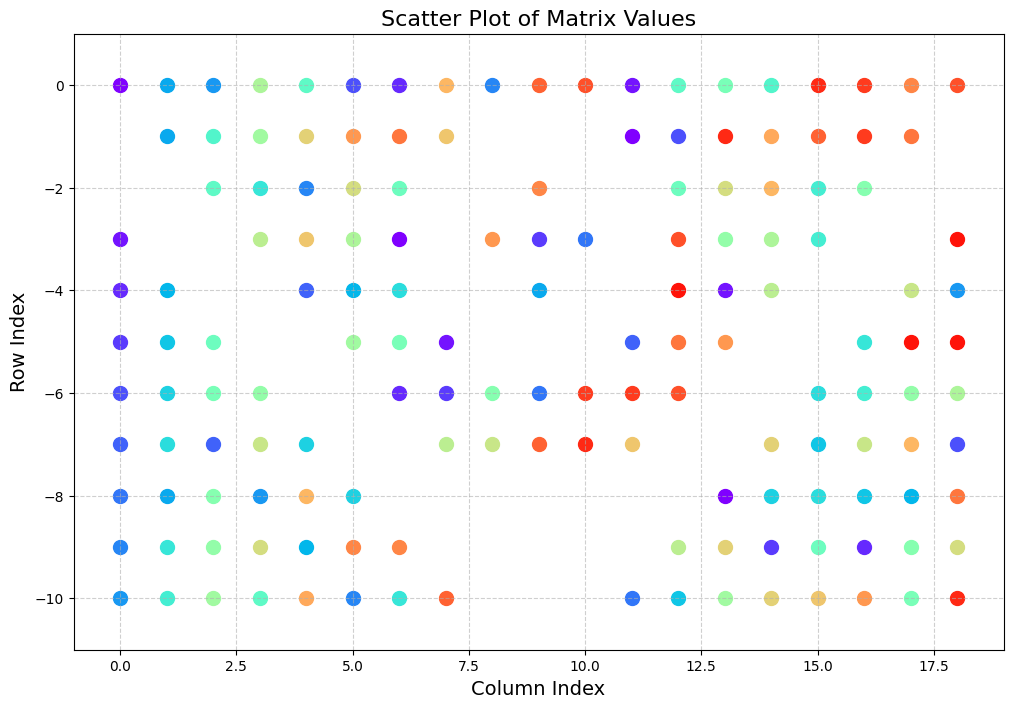

In [5]:
import numpy as np
import cv2
from pathlib import Path
dbg = 1

# check if a image is blank
# we compare the middle 1/3 of the image, if it fills with the same color, then blank
def check_blank(im):
    cropped_image = im.crop((13, 13, 26, 26))
    im_array = np.array(cropped_image).reshape(-1,3)
    return np.array_equal(np.max(im_array, axis=0) - np.min(im_array, axis=0),  np.array([0,0,0]))

def get_same_imgs_2(square,image,SQUARE_WIDTH,SQUARE_HEIGHT):# Convert PIL images to OpenCV format (NumPy arrays)
    # match template with cv2
    # this step compares grey value
    search_image = np.array(image)
    template = np.array(square)
    
    # Convert to grayscale (if needed)
    if search_image.shape[-1] == 4:  # If RGBA, remove alpha channel
        search_image = search_image[:, :, :3]
    if template.shape[-1] == 4:
        template = template[:, :, :3]
        
    # Crop edges of the template (adjust the crop dimensions as needed)
    crop_top = crop_bottom = crop_left = crop_right = 5
    cropped_template = template[crop_top:template.shape[0]-crop_bottom, 
                                 crop_left:template.shape[1]-crop_right]

    # Match template on each color channel separately
    rgb_match = True
    if rgb_match:
        result_r = cv2.matchTemplate(search_image[:, :, 0], cropped_template[:, :, 0], cv2.TM_CCOEFF_NORMED)
        result_g = cv2.matchTemplate(search_image[:, :, 1], cropped_template[:, :, 1], cv2.TM_CCOEFF_NORMED)
        result_b = cv2.matchTemplate(search_image[:, :, 2], cropped_template[:, :, 2], cv2.TM_CCOEFF_NORMED)

        # Combine the results by averaging them
        result = np.maximum(result_r,result_g,result_b)
    else:
        # Convert both images to grayscale
        image_gray = cv2.cvtColor(search_image, cv2.COLOR_RGB2GRAY)
        template_gray = cv2.cvtColor(cropped_template, cv2.COLOR_RGB2GRAY)

        # Perform template matching
        result = cv2.matchTemplate(image_gray, template_gray, cv2.TM_CCOEFF_NORMED)
    # Threshold for a match
    threshold = 0.8  # Matches above 80% confidence

    # Find all locations where the match is above the threshold
    locations = np.where(result >= threshold)

    # Extract the dimensions of the template
    template_height, template_width = cropped_template.shape[:2]

    # Calculate the center coordinates of each match
    pixel_coordinates = [
        (int(x + template_width / 2), int(y + template_height / 2))
        for x, y in zip(locations[1], locations[0])
    ]
    
    coords = set()
    
    for x,y in pixel_coordinates:
        coords.add((int(x/SQUARE_WIDTH),int(y/SQUARE_HEIGHT)))
    
    coords = list(coords)
    print(coords)
    res = []
    # remove some different color figures
    for x,y in coords:
        square_xy = image.crop((
            x * SQUARE_WIDTH, y * SQUARE_HEIGHT,
            (x+1) * SQUARE_WIDTH, (y+1) * SQUARE_HEIGHT))           
        # first cast into same shape
        min_shape =  [min(x, y) for x, y in zip(np.array(square_xy).shape, np.array(square).shape)]
        # print(min_shape)
        cs = 5 # crop size
        crop_square_xy = np.array(square_xy).astype(np.int64)[cs:min_shape[0]-cs,cs:min_shape[1]-cs,:]
        crop_square = np.array(square).astype(np.int64)[cs:min_shape[0]-cs,cs:min_shape[1]-cs,:]
        diff = crop_square_xy-crop_square
        dist = np.linalg.norm(diff.flatten(),ord=1)
        if dist < 100000.:
            res.append((x,y))
    return res
def get_map_2(image):
    max_ind = 1
    _, _, area_width, area_height = image.getbbox()
    global SQUARE_WIDTH, SQUARE_HEIGHT
    SQUARE_WIDTH = area_width / COL_NUM
    SQUARE_HEIGHT = area_height / ROW_NUM
    game_map = [ [-1 for j in  range(ROW_NUM)] for i in range(COL_NUM)]
    for x in range(COL_NUM):
        for y in range(ROW_NUM):
            square = image.crop((
                x * SQUARE_WIDTH, y * SQUARE_HEIGHT,
                (x+1) * SQUARE_WIDTH, (y+1) * SQUARE_HEIGHT))
            if dbg:
                save_path = Path("log/figs/({x},{y}).png".format(x=x,y=y))
                save_path.parent.mkdir(parents=True, exist_ok=True)
                square.save(save_path)
            if check_blank(square) == True:
                assert game_map[x][y] == -1
                game_map[x][y] = 0
            elif game_map[x][y] == -1:
                same_imgs = get_same_imgs_2(square,image,SQUARE_WIDTH,SQUARE_HEIGHT)
                print("(x,y)=({x},{y})".format(x=x,y=y),same_imgs)
                for ix,iy in same_imgs:
                    print("(ix,iy)=({ix},{iy})".format(ix=ix,iy=iy))
                    assert game_map[ix][iy] == -1
                    game_map[ix][iy] = max_ind
                max_ind += 1
                
    return game_map



im = Image.open('cropped_screen.png')
map_dbg = get_map_2(im)

with open('map_dbg.json','w') as file:
    json.dump(map_dbg,file)
    

plot_map('map_dbg.json',None,show=1)
    

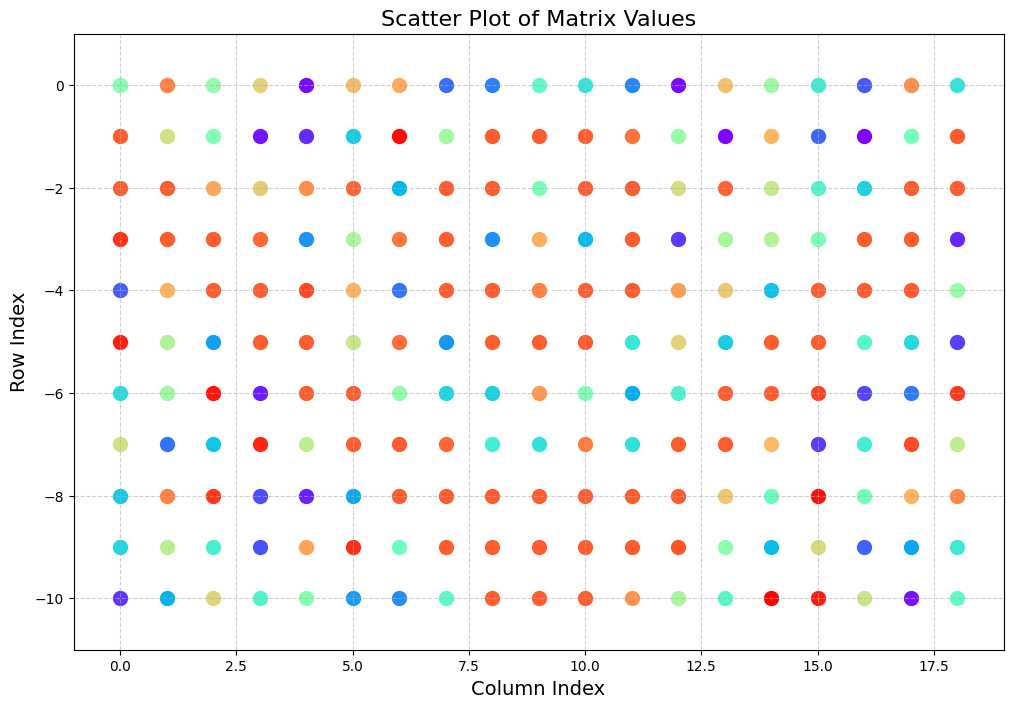

In [6]:
def get_map_2(image):
    game_map = []
    _, _, area_width, area_height = image.getbbox()
    global SQUARE_WIDTH, SQUARE_HEIGHT
    SQUARE_WIDTH = area_width / COL_NUM
    SQUARE_HEIGHT = area_height / ROW_NUM
    for x in range(COL_NUM):
        a_col = []
        for y in range(ROW_NUM):
            square = image.crop((
                x * SQUARE_WIDTH, y * SQUARE_HEIGHT,
                (x+1) * SQUARE_WIDTH, (y+1) * SQUARE_HEIGHT))
            a_col.append(get_image_hash(square))
            #square.save("log/figs/({x},{y}).png".format(x=x,y=y))
        game_map.append(a_col)
    return game_map

#Image.open('cropped_screen.png').show()
map_dbg = get_map(Image.open('cropped_screen.png'))

with open('map_dbg.json','w') as file:
    json.dump(map_dbg,file)
    

plot_map('map_dbg.json',None,show=1)

In [7]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Load the images
image1_path = 'figs/(6,2).png'
image2_path = 'figs/(6,6).png'

image1 = Image.open(image1_path)
image2 = Image.open(image2_path)

# Convert images to grayscale for SSIM calculation
image1_gray = image1.convert("L")
image2_gray = image2.convert("L")

# Convert images to numpy arrays
image1_array = np.array(image1_gray)
image2_array = np.array(image2_gray)

ssim_score, ssim_diff = ssim(image1_array, image2_array, full=True)

print('score:',ssim_score)


#image2.show()

# Convert images to RGB arrays
cs = 5 # crop size
rgb_image1 = np.array(image1).astype(np.int64)[cs:43-cs,cs:38-cs,:]
rgb_image2 = np.array(image2).astype(np.int64)[cs:43-cs,cs:38-cs,:]
# [:43,:38,:]
# Print RGB values

print("RGB values of diff:")
diff = rgb_image1 - rgb_image2

print("norm",np.linalg.norm(diff))
#print(rgb_image1.dtype)
#print(rgb_image2)
print(rgb_image1[:,:,2])
print('---')
print(rgb_image2[:,:,2])

#print("\nRGB values of Image 2:")
#print(rgb_image2)

# Check if the two images are identical
#are_images_equal = np.array_equal(rgb_image1, rgb_image2)
#print("\nAre the two images identical? ->", are_images_equal)


score: 0.25327663874488743
RGB values of diff:
norm 4485.947837414074
[[184 184 184 184 184 184 184 184 184 184 184 184 184 184 184 184 184 184
  184 184 184 184 184 184 184 184 184 184]
 [184 184 184 184 184 184 184 184 184 184 184 184 184 184 184 184 184 184
  184 184 184 184 184 184 184 184 184 184]
 [184 184 184 184 184 184 184 184 184 184 184 184 184 184 184 184 184 184
  184 184 184 184 184 184 184 184 184 184]
 [183 180 178 180 183 179 182 184 182 178 178 178 178 178 178 178 178 181
  182 178 178 178 178 178 179 183 180 181]
 [180 177 176 177 180 176 179 180 179 176 176 176 176 176 176 176 176 178
  179 176 176 176 176 176 176 180 177 178]
 [176 176 175 174 176 176 176 176 178 185 196 198 198 198 196 187 179 176
  176 176 176 176 176 176 176 176 176 176]
 [176 176 172 167 169 174 175 179 190 209 244 248 248 248 242 210 190 181
  178 176 176 176 176 176 176 176 176 176]
 [176 176 168 144 111 162 169 205 241 244 247 248 248 244 229 191 224 223
  196 176 176 176 176 176 176 176 176

In [8]:
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm

# Paths to the uploaded images
file_paths = [f"../({x},{y}).png" for x in range(19) for y in range(11) if os.path.exists(f"../({x},{y}).png")]

# Load and preprocess images
images = []
for file_path in tqdm(file_paths, desc="Loading and preprocessing images"):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        # Apply differentiation (Laplacian for edge detection)
        differentiated_image = cv2.Laplacian(image, cv2.CV_64F)
        images.append(differentiated_image)

# Resize images to a common size for feature extraction
common_size = (50, 50)
resized_images = [cv2.resize(image, common_size) for image in images]

# Flatten images into feature vectors
feature_vectors = [image.flatten() for image in resized_images]

# Convert feature vectors into a numpy array
X = np.array(feature_vectors)

# Determine the optimal number of clusters using the elbow method
inertia = []
for k in range(1, 15):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 15), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method to Determine Optimal Clusters")
plt.show()

# Apply KMeans clustering to classify the images (choose optimal `n_clusters` from elbow method results)
optimal_clusters = 9  # Replace this based on elbow method results
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Visualize differentiated images in a grid layout with cluster labels
n_rows, n_cols = 4, 5  # Adjust grid size as needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten()

for i, (ax, image, label) in enumerate(zip(axes, resized_images, labels)):
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Cluster: {label}')
    ax.axis('off')

# Hide unused subplots
for ax in axes[len(resized_images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Output the cluster labels for further analysis
labels


Loading and preprocessing images: 0it [00:00, ?it/s]


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
import cv2

def fig_match(template_path,search_image_path):

    # Read the images
    template = cv2.imread(template_path, cv2.IMREAD_UNCHANGED)
    search_image = cv2.imread(search_image_path, cv2.IMREAD_UNCHANGED)

    # Crop edges of a.png (adjust the crop dimensions as needed)
    # Define the cropping margins (top, bottom, left, right)
    crop_top = crop_bottom = crop_left = crop_right = 7
    # Crop the image
    cropped_template = template[crop_top:template.shape[0]-crop_bottom, 
                                crop_left:template.shape[1]-crop_right]

    # Match template
    result = cv2.matchTemplate(search_image, cropped_template, cv2.TM_CCOEFF_NORMED)

    # Get the best match position
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Threshold for a match (adjust if needed)
    threshold = 0.8  # Matches above 80% confidence
    if max_val >= threshold:
        return True

    else:
        return False


In [ ]:
fig_match("../(0,1).png","../(0,3).png")

False

Building similarity matrix: 100%|██████████| 209/209 [00:04<00:00, 46.55it/s]
c:\Users\hewen\anaconda3\envs\gameAI\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


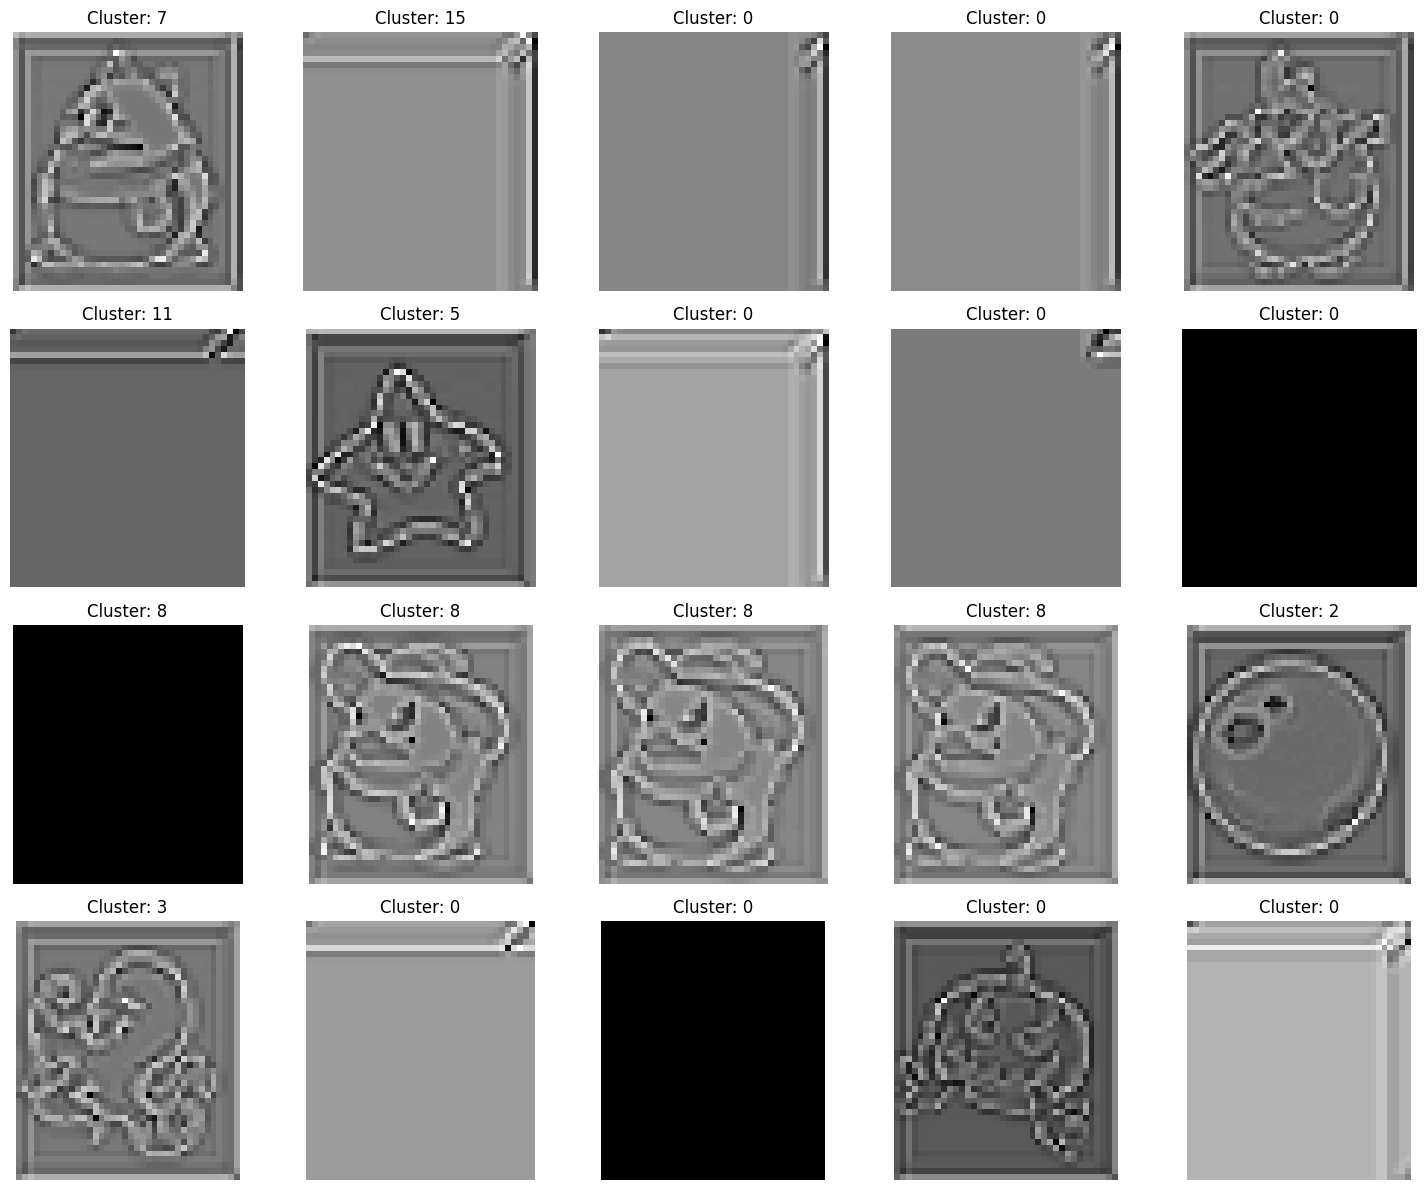

array([ 7, 15,  0,  0,  0, 11,  5,  0,  0,  0,  8,  8,  8,  8,  2,  3,  0,
        0,  0,  0,  0,  0,  0,  9,  0,  0,  0, 13,  0,  0,  0,  0,  7,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6,  2,  2, 17, 16,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,
        0,  0,  0,  0,  4,  0,  0,  0, 12,  0,  0,  0,  0,  6, 14,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  3,  0,  1,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  5,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  3,  0,  0,  0,
        0,  0,  0,  0,  0], dtype=int64)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

file_paths = [f"../({x},{y}).png" for x in range(19) for y in range(11) if os.path.exists(f"../({x},{y}).png")]





# Build a similarity matrix using fig_match
n_images = len(file_paths)
similarity_matrix = np.zeros((n_images, n_images), dtype=int)

for i in tqdm(range(n_images), desc="Building similarity matrix"):
    for j in range(i, n_images):
        if fig_match(file_paths[i], file_paths[j]):
            similarity_matrix[i, j] = 1
            similarity_matrix[j, i] = 1

# Use Agglomerative Clustering for grouping based on the similarity matrix
clustering = AgglomerativeClustering(n_clusters=None, affinity="precomputed", linkage="average", distance_threshold=0.5)
labels = clustering.fit_predict(1 - similarity_matrix)  # Convert similarity to distance

# Visualize results
n_rows, n_cols = 4, 5  # Adjust grid size as needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten()

for i, (ax, image, label) in enumerate(zip(axes, images, labels)):
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Cluster: {label}')
    ax.axis('off')

# Hide unused subplots
for ax in axes[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Output cluster labels
labels


In [ ]:
import cv2
import numpy as np

def match_all(template_path, search_image_path):
    """
    Finds all center coordinates where the template matches the search image.

    Args:
        template_path (str): Path to the template image.
        search_image_path (str): Path to the search image.

    Returns:
        list of tuples: A list of (center_x, center_y) coordinates where matches are found.
    """
    # Read the images
    template = cv2.imread(template_path, cv2.IMREAD_UNCHANGED)
    search_image = cv2.imread(search_image_path, cv2.IMREAD_UNCHANGED)

    # Crop edges of the template (adjust the crop dimensions as needed)
    crop_top = crop_bottom = crop_left = crop_right = 7
    cropped_template = template[crop_top:template.shape[0]-crop_bottom, 
                                 crop_left:template.shape[1]-crop_right]

    # Match template
    result = cv2.matchTemplate(search_image, cropped_template, cv2.TM_CCOEFF_NORMED)

    # Threshold for a match
    threshold = 0.8  # Matches above 80% confidence

    # Find all locations where the match is above the threshold
    locations = np.where(result >= threshold)

    # Extract the dimensions of the template
    template_height, template_width = cropped_template.shape[:2]

    # Calculate the center coordinates of each match
    center_coordinates = [
        (int(x + template_width / 2), int(y + template_height / 2))
        for x, y in zip(locations[1], locations[0])
    ]

    return center_coordinates


In [ ]:
match_all("../(1,3).png","../cropped_screen.png")

[(57, 152),
 (58, 152),
 (59, 152),
 (174, 152),
 (175, 152),
 (57, 153),
 (58, 153),
 (59, 153),
 (173, 153),
 (174, 153),
 (175, 153),
 (176, 153),
 (57, 154),
 (58, 154),
 (59, 154),
 (173, 154),
 (174, 154),
 (175, 154),
 (173, 196),
 (174, 196),
 (175, 196),
 (173, 197),
 (174, 197),
 (175, 197),
 (176, 197),
 (174, 198),
 (678, 458),
 (679, 458),
 (677, 459),
 (678, 459),
 (679, 459),
 (677, 460),
 (678, 460),
 (679, 460)]